In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [3]:
PATH = Path('data/pascal')
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

# Get data

In [4]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [5]:
annotations = pd.DataFrame(trn_j['annotations'])
images = pd.DataFrame(trn_j['images'])
categories = pd.DataFrame(trn_j['categories'])

In [ ]:
# {image_id: [(box coordinates, category_id),()]}

In [ ]:
annotations.head()

In [ ]:
images.head()

In [ ]:
categories.head()

In [22]:
data = (annotations
        .merge(images, how='left', left_on='image_id', right_on='id')
        .merge(categories, how='left', left_on='category_id', right_on='id'))
data.head()

area                  bbox  category_id  id_x  ignore  image_id  iscrowd  \
0  34104   [155, 96, 196, 174]            7     1       0        12        0   
1  13110    [184, 61, 95, 138]           15     2       0        17        0   
2  81326    [89, 77, 314, 259]           13     3       0        17        0   
3  64227    [8, 229, 237, 271]            2     4       0        23        0   
4  29505  [229, 219, 105, 281]            2     5       0        23        0   

                                 segmentation   file_name  height  id_y  \
0    [[155, 96, 155, 270, 351, 270, 351, 96]]  000012.jpg     333    12   
1    [[184, 61, 184, 199, 279, 199, 279, 61]]  000017.jpg     364    17   
2      [[89, 77, 89, 336, 403, 336, 403, 77]]  000017.jpg     364    17   
3      [[8, 229, 8, 500, 245, 500, 245, 229]]  000023.jpg     500    23   
4  [[229, 219, 229, 500, 334, 500, 334, 219]]  000023.jpg     500    23   

   width  id     name supercategory  
0    500   7      car          none  
1    480  15   person          none  
2    480  13    horse          none  
3    334   2  bicycle          none  
4    334   2  bicycle          none

In [23]:
# remove any ignore
# len(data) = 7844
data = data[data.ignore != 1]
len(data)

6301

In [ ]:
# example of how to create the largest bounding box table with pandas from previous lesson

# largest_bbox = data.pivot_table(index='file_name', aggfunc='max', values='area').reset_index()
# largest_bbox = largest_bbox.merge(data[['area', 'bbox', 'image_id', 'file_name', 'name']], how='left')
# largest_bbox.head()

# Helper Functions

In [6]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [7]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

In [8]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

# Set up dataframe

In [19]:
df = images[['file_name']].copy()

In [20]:
def bb_hw_pandas(x):
    return [x[1], x[0], x[1]+x[3]-1, x[0]+x[2]-1]

In [24]:
orig_boxes = []
diff_boxes = []
cat_names = []
cat_ids = []
for idx,r in df.iterrows():
    anno_rows = data.loc[data.file_name == r.file_name]
    boxes = anno_rows['bbox'].values.tolist()
    orig_boxes.append(np.concatenate(boxes))
    diff_boxes.append(np.concatenate([bb_hw_pandas(x) for x in boxes]))
    cat_names.append(anno_rows['name'].values.tolist())
    cat_ids.append(np.array(anno_rows['category_id'].values))
df['hw_boxes'] = [' '.join(str(p) for p in o) for o in orig_boxes]
df['b_boxes'] = [' '.join(str(p) for p in o) for o in diff_boxes]
df['cat_names'] = [' '.join(str(p) for p in o) for o in cat_names]
cat_ids = np.array(cat_ids)
# df['cat_ids'] = [' '.join(str(p) for p in o) for o in cat_ids]

In [11]:
df.head()

file_name                                           hw_boxes  \
0  000012.jpg                                     155 96 196 174   
1  000017.jpg                        184 61 95 138 89 77 314 259   
2  000023.jpg  8 229 237 271 229 219 105 281 1 0 116 369 2 1 ...   
3  000026.jpg                                      89 124 248 88   
4  000032.jpg  103 77 272 106 132 87 65 36 194 179 19 50 25 1...   

                                             b_boxes  \
0                                     96 155 269 350   
1                       61 184 198 278 77 89 335 402   
2  229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...   
3                                     124 89 211 336   
4  77 103 182 374 87 132 122 196 179 194 228 212 ...   

                              cat_names  
0                                   car  
1                          person horse  
2  bicycle bicycle person person person  
3                                   car  
4     aeroplane aeroplane person person

In [25]:
cat_ids

array([array([7]), array([15, 13]), array([ 2,  2, 15, 15, 15]), ..., array([18,  9, 15, 15, 15]),
       array([7]), array([12])], dtype=object)

# Multiple Classes only

In [20]:
multi_label_csv = PATH/'tmp/multi_label.csv'

In [ ]:
# df.to_csv(multi_label_csv, columns=['file_name', 'cat_names'], index=False)

In [7]:
f_model = resnet34
sz = 224
bs = 64

In [21]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, multi_label_csv, tfms=tfms, bs=bs)
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

/home/paperspace/fastai/courses/dl2/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/paperspace/fastai/courses/dl2/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [22]:
learn.lr_find()

epoch      trn_loss   val_loss   <lambda>                  
    0      1.083884   11.811324  0.5722    



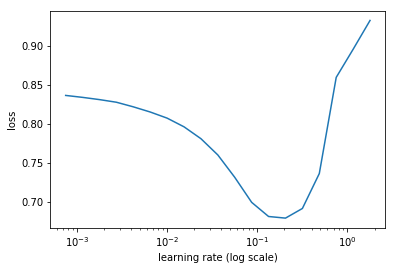

In [23]:
learn.sched.plot(n_skip_end=2)

In [24]:
lr = 6e-2

In [27]:
learn.fit(lr, 1, cycle_len=1, use_clr=(32,5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.11628    0.092335   0.9727    



[0.09233545166254044, 0.9726999917030335]

In [28]:
lrs = np.array([lr/100, lr/10, lr])

In [29]:
learn.freeze_to(-2)

In [ ]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [30]:
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32,5))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.103236   0.155578   0.96      
    1      0.095711   0.113873   0.967                      
    2      0.074212   0.092019   0.9705                     
    3      0.053307   0.090675   0.9712                     
    4      0.037899   0.090125   0.9729                     



[0.09012477153539658, 0.97289999294281]

In [31]:
learn.save('multi-label')

In [32]:
y = learn.predict()
x,_ = next(iter(md.val_dl))
x = to_np(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


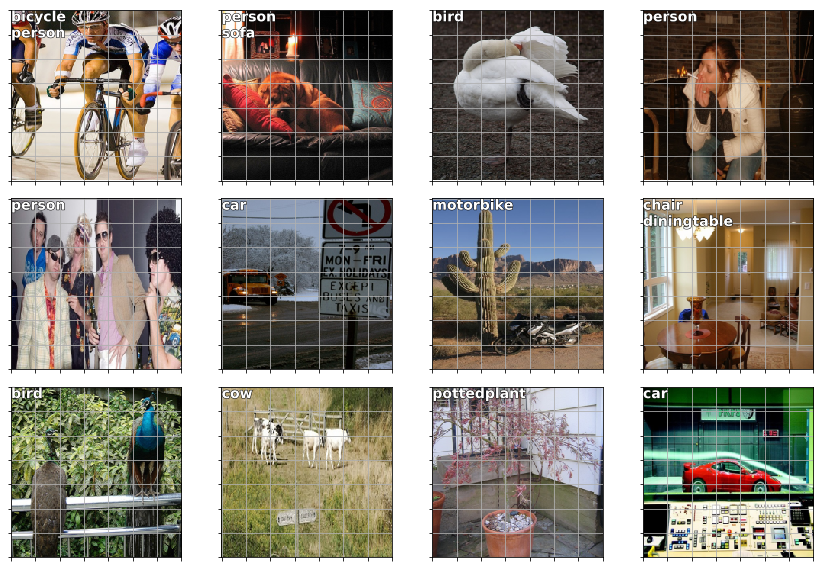

In [33]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    ya = np.nonzero(y[i]>0.4)[0]
    b = '\n'.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

# Multiple Objects

Need to use the model data set from multi box because 'continuous' flag in ImageClassifierData converts y to floats in the backend and doesn't play nice with a tuple of data (even if it's already in float format b/c it expects csv strings)

In [78]:
multi_box_csv = PATH/'tmp/multi_box.csv'

In [10]:
df = pd.read_csv(multi_box_csv)
df.head()

file_name                                            b_boxes
0  000012.jpg                                     96 155 269 350
1  000017.jpg                       61 184 198 278 77 89 335 402
2  000023.jpg  229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...
3  000026.jpg                                     124 89 211 336
4  000032.jpg  77 103 182 374 87 132 122 196 179 194 228 212 ...

In [212]:
# df.to_csv(multi_box_csv, columns=['file_name', 'b_boxes'], index=False)

In [79]:
f_model = resnet34
sz = 224
bs = 64

In [80]:
tfm_y = TfmType.COORD
aug_tfms = [RandomRotate(10, p=0.5, tfm_y=tfm_y),
            RandomLighting(0.05, 0.05, tfm_y=tfm_y),
            RandomFlip(tfm_y=tfm_y)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, multi_box_csv, tfms=tfms, bs=bs, continuous=True)

## Check image transforms

In [13]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

def show_aug_boxes(ax, im, bbox):
    bbs = [bb_hw(o) for o in bbox.reshape(-1,4)]
    ax = show_img(im, ax=ax)
    for i,b in enumerate(bbs):
        if(b[2]>0):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])
            
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [14]:
x,y = to_np(next(iter(md.aug_dl)))
x = md.val_ds.denorm(x)

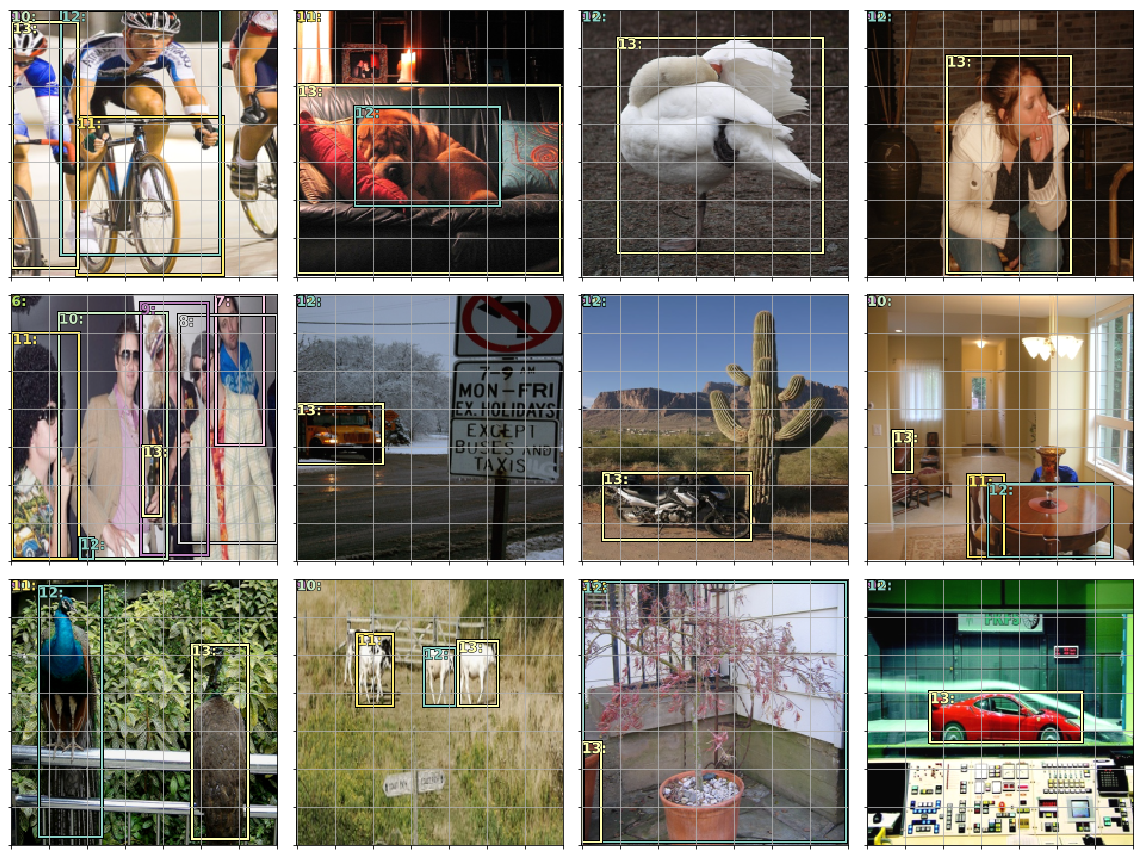

In [16]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_aug_boxes(ax, x[i], y[i])
plt.tight_layout()

## Add cat_ids into the dataset (pre-separated into trn/val)

My categories are bu

In [70]:
PATH = Path('data/pascal')
trn_j = json.load((PATH / 'pascal_train2007.json').open())
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

In [71]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
    return trn_anno

trn_anno = get_trn_anno()

In [72]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc]); mcs

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [73]:
cat_ids

array([array([7]), array([15, 13]), array([ 2,  2, 15, 15, 15]), ..., array([18,  9, 15, 15, 15]),
       array([7]), array([12])], dtype=object)

In [76]:
cat_ids = mcs

In [17]:
# id2cat = list(categories.name)
# id2cat.insert(0,'background')   # background as 0 and offset indices (df idx starts at 0, categories started at 1)
# cat2id = {v:k for k,v in enumerate(id2cat)}

In [77]:
idxs = get_cv_idxs(len(cat_ids))
((val_cats, trn_cats),)= split_by_idx(idxs, cat_ids)

In [27]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [81]:
md.trn_dl.dataset = ConcatLblDataset(md.trn_ds, trn_cats)
md.val_dl.dataset = ConcatLblDataset(md.val_ds, val_cats)

## Check datasets

In [29]:
# val
x,y = to_np(next(iter(md.val_dl)))
x = md.val_ds.ds.denorm(x)

In [82]:
# trn
x,y = to_np(next(iter(md.trn_dl)))
x = md.trn_ds.ds.denorm(x)

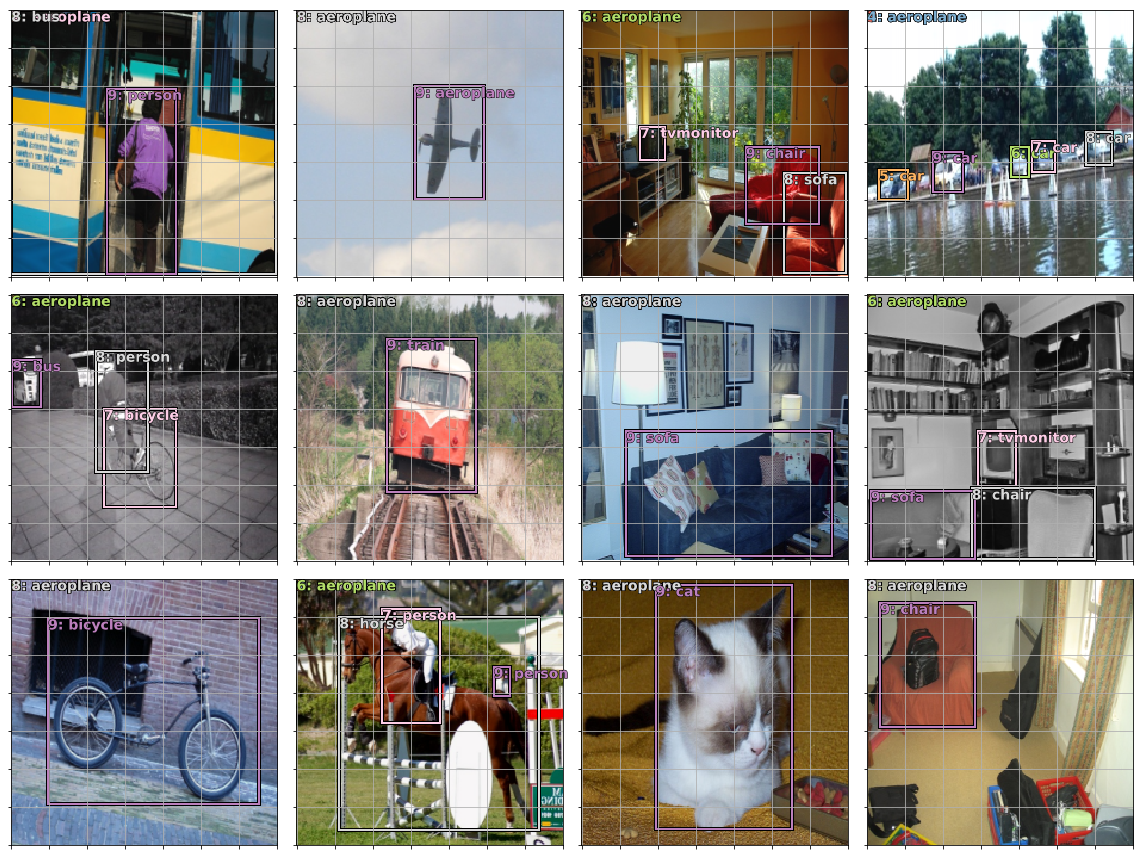

In [83]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

## Set up Model

We're first going to make a model that predicts what object is in each cell of a 4x4 grid using anchor boxes
- anc_grid = how many cells (squared) in the grid
- anc_offset = center offsets
- anc_x = x coordinates for centers
- anc_y = y coordinates for centers
- anc_ctrs - coordinates (x,y) for the grid centers
- anc_sizes - size of the quadrants
- anchors - center (x,y), height, width
- anchors_cnr - lower left (x,y), height, width

### Anchor boxes

In [31]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchors

tensor([[ 0.1250,  0.1250,  0.2500,  0.2500],
        [ 0.1250,  0.3750,  0.2500,  0.2500],
        [ 0.1250,  0.6250,  0.2500,  0.2500],
        [ 0.1250,  0.8750,  0.2500,  0.2500],
        [ 0.3750,  0.1250,  0.2500,  0.2500],
        [ 0.3750,  0.3750,  0.2500,  0.2500],
        [ 0.3750,  0.6250,  0.2500,  0.2500],
        [ 0.3750,  0.8750,  0.2500,  0.2500],
        [ 0.6250,  0.1250,  0.2500,  0.2500],
        [ 0.6250,  0.3750,  0.2500,  0.2500],
        [ 0.6250,  0.6250,  0.2500,  0.2500],
        [ 0.6250,  0.8750,  0.2500,  0.2500],
        [ 0.8750,  0.1250,  0.2500,  0.2500],
        [ 0.8750,  0.3750,  0.2500,  0.2500],
        [ 0.8750,  0.6250,  0.2500,  0.2500],
        [ 0.8750,  0.8750,  0.2500,  0.2500]], device='cuda:0')

In [32]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1);
grid_sizes

tensor([[ 0.2500]], device='cuda:0')

In [33]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [34]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

tensor([[ 0.0000,  0.0000,  0.2500,  0.2500],
        [ 0.0000,  0.2500,  0.2500,  0.5000],
        [ 0.0000,  0.5000,  0.2500,  0.7500],
        [ 0.0000,  0.7500,  0.2500,  1.0000],
        [ 0.2500,  0.0000,  0.5000,  0.2500],
        [ 0.2500,  0.2500,  0.5000,  0.5000],
        [ 0.2500,  0.5000,  0.5000,  0.7500],
        [ 0.2500,  0.7500,  0.5000,  1.0000],
        [ 0.5000,  0.0000,  0.7500,  0.2500],
        [ 0.5000,  0.2500,  0.7500,  0.5000],
        [ 0.5000,  0.5000,  0.7500,  0.7500],
        [ 0.5000,  0.7500,  0.7500,  1.0000],
        [ 0.7500,  0.0000,  1.0000,  0.2500],
        [ 0.7500,  0.2500,  1.0000,  0.5000],
        [ 0.7500,  0.5000,  1.0000,  0.7500],
        [ 0.7500,  0.7500,  1.0000,  1.0000]], device='cuda:0')

### Custom head

In [86]:
# How many activations do we need?
n_clas = len(id2cat)+1
n_act = k*(4+n_clas)
n_act

25

In [100]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self,x):
        return self.drop(self.bn(F.relu(self.conv(x))))

# loss function expects flattened tensor
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs, -1, nf//k)

In [101]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        # class
        self.oconv1 = nn.Conv2d(nin, n_clas*k, 3, padding=1)
        # bounding box
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self,x):
        # total activation output: n_act == 25
        return [flatten_conv(self.oconv1(x), self.k), flatten_conv(self.oconv2(x), self.k)]

In [102]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        # extra layer of calculation w/out changing geometry
        self.sconv0 = StdConv(512,256, stride=1)
        self.sconv2 = StdConv(256,256)   # output => (64,256,4,4) as per our anchor boxes
        self.out = OutConv(k, 256, bias)
        
    def forward(self,x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv2(x)
        return self.out(x)
    
head_reg4 = SSD_Head(k, -3.0)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

### Loss Function

Network Output: 16 sets of 25 activations, one per anchor box.  
Loss Function: Compare each set of activations (coordinates, class probabilities) with actuals per anchor cell  
    Must first match actuals w/ anchor cells

In [103]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data] 

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)  # have background (num_classes+1)
        # remove background
        t = V(t[:,:-1].contiguous())
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

In [104]:
## Jaccard IoU - intersection over union

def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [105]:
bbox,clas = y
# bbox = bbox.view(-1,4)/sz
bbox.shape, clas.shape

(torch.Size([64, 56]), torch.Size([64, 14]))

In [106]:
# tensor has to be a specific shape but number of labels can vary from image to image
# fastai pads with zeros to accomodate this
# this function is getting rid of the unnecessary zeros
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

# activation to bounding box
# need to convert activations into some way of scaling default anchor box positions
# shift the centers/height and width -> up to half the size of the box
def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [107]:
x,y = next(iter(md.val_dl))
# x,y = V(x).cpu(),V(y)
x,y = V(x),V(y)

In [97]:
learn.model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [108]:
preds = learn.model(x)
b_clas,b_bb = preds
b_clas.shape, b_bb.shape

(torch.Size([64, 16, 21]), torch.Size([64, 16, 4]))

In [109]:
ssd_loss(preds, y, True)

tensor([ 0.1947,  0.1168,  0.2652], device='cuda:0')
tensor([ 0.2885,  0.0888], device='cuda:0')
tensor(1.00000e-02 *
       [ 9.9027], device='cuda:0')
tensor([ 0.1608], device='cuda:0')
tensor([ 0.3237,  0.2153,  0.2558,  0.2013,  0.2526,  0.0485,  0.0879], device='cuda:0')
tensor([ 0.3258], device='cuda:0')
tensor([ 0.2704], device='cuda:0')
tensor([ 0.3985,  0.4538,  0.1897], device='cuda:0')
tensor([ 0.1527,  0.1863], device='cuda:0')
tensor([ 0.3426,  0.3249,  0.5062], device='cuda:0')
tensor([ 0.0642,  0.2506], device='cuda:0')
tensor([ 0.2027], device='cuda:0')
tensor([ 0.2418,  0.2337,  0.2590], device='cuda:0')
tensor(1.00000e-02 *
       [ 8.4642], device='cuda:0')
tensor([ 0.3652,  0.1377], device='cuda:0')
tensor(1.00000e-02 *
       [ 9.5146,  5.7398], device='cuda:0')
tensor([ 0.2041,  0.1148,  0.1341,  0.1650,  0.0384,  0.2213,  0.1477,
         0.2520,  0.2531,  0.2129,  0.2144,  0.1795,  0.3002,  0.3057], device='cuda:0')
tensor([ 0.2097,  0.2182,  0.2786,  0.2973], d

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor(83.6754, device='cuda:0')

In [110]:
learn.crit = ssd_loss

In [111]:
learn.lr_find()

 81%|████████▏ | 26/32 [00:17<00:03,  1.53it/s, loss=328] 

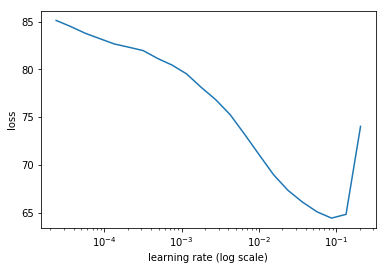

In [116]:
learn.sched.plot(2,1)

In [117]:
lr = 7e-3

In [118]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

epoch      trn_loss   val_loss                            
    0      40.911675  34.876704 
    1      33.832096  28.948077                           
    2      30.015403  27.468501                           
    3      27.318356  26.914769                           
    4      25.288617  26.349937                           


[26.349936752319337]

In [119]:
learn.save('anchor4x4')

### Testing

In [120]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
learn.model.eval()
batch = learn.model(x)
b_clas,b_bb = batch
b_clas.size(),b_bb.size()

(torch.Size([64, 16, 21]), torch.Size([64, 16, 4]))

In [121]:
idx=7
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=md.val_ds.ds.denorm(to_np(x))[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])
bbox,clas

(tensor([[ 0.6786,  0.4866,  0.9911,  0.6250],
         [ 0.7098,  0.0848,  0.9911,  0.5491],
         [ 0.5134,  0.8304,  0.6696,  0.9063]], device='cuda:0'),
 tensor([  8,  10,  17], device='cuda:0'))

In [122]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

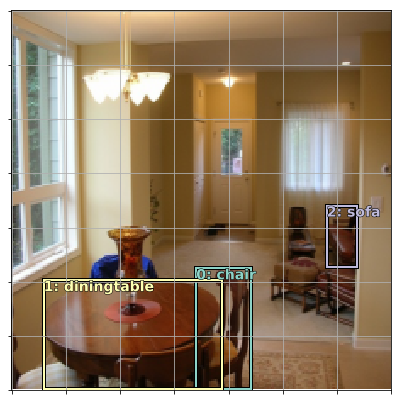

In [123]:
# ground truth
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

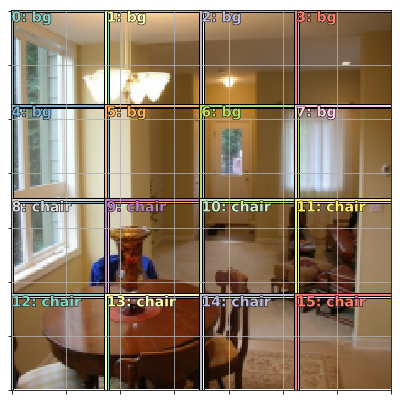

In [124]:
# anchor boxes
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

In [125]:
a_ic = actn_to_bb(b_bboxi, anchors)

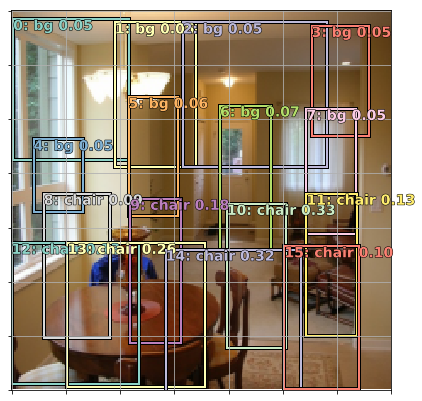

In [126]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh=0.0)

In [127]:
overlaps = jaccard(bbox.data, anchor_cnr.data)
overlaps

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0091,  0.0922,  0.0000,  0.0000,  0.0315,
          0.3985,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0356,  0.0549,  0.0103,  0.0000,  0.2598,  0.4538,
          0.0653,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.1897,  0.0000,  0.0000,
          0.0000,  0.0000]], device='cuda:0')

In [128]:
overlaps.max(1)

(tensor([ 0.3985,  0.4538,  0.1897], device='cuda:0'),
 tensor([ 14,  13,  11], device='cuda:0'))

In [129]:
overlaps.max(0)

(tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0356,  0.0549,  0.0922,  0.1897,  0.2598,  0.4538,
          0.3985,  0.0000], device='cuda:0'),
 tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  2,  1,  1,
          0,  0], device='cuda:0'))

In [130]:
gt_overlap,gt_idx = map_to_ground_truth(overlaps)
gt_overlap,gt_idx

(tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0356,  0.0549,  0.0922,  1.9900,  0.2598,  1.9900,
          1.9900,  0.0000], device='cuda:0'),
 tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  2,  1,  1,
          0,  0], device='cuda:0'))

In [131]:
gt_clas = clas[gt_idx]; gt_clas

tensor([  8,   8,   8,   8,   8,   8,   8,   8,  10,  10,   8,  17,
         10,  10,   8,   8], device='cuda:0')

In [132]:
thresh = 0.5
pos = gt_overlap > thresh
pos_idx = torch.nonzero(pos)[:,0]
neg_idx = torch.nonzero(1-pos)[:,0]
pos_idx

tensor([ 11,  13,  14], device='cuda:0')

In [133]:
gt_clas[1-pos] = len(id2cat)
[id2cat[o] if o<len(id2cat) else 'bg' for o in gt_clas.data]

['bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'sofa',
 'bg',
 'diningtable',
 'chair',
 'bg']

In [134]:
gt_bbox = bbox[gt_idx]
loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()  # L1 loss
clas_loss  = F.cross_entropy(b_clasi, gt_clas)
loc_loss,clas_loss

(tensor(1.00000e-02 *
        6.2528, device='cuda:0'), tensor(1.0234, device='cuda:0'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


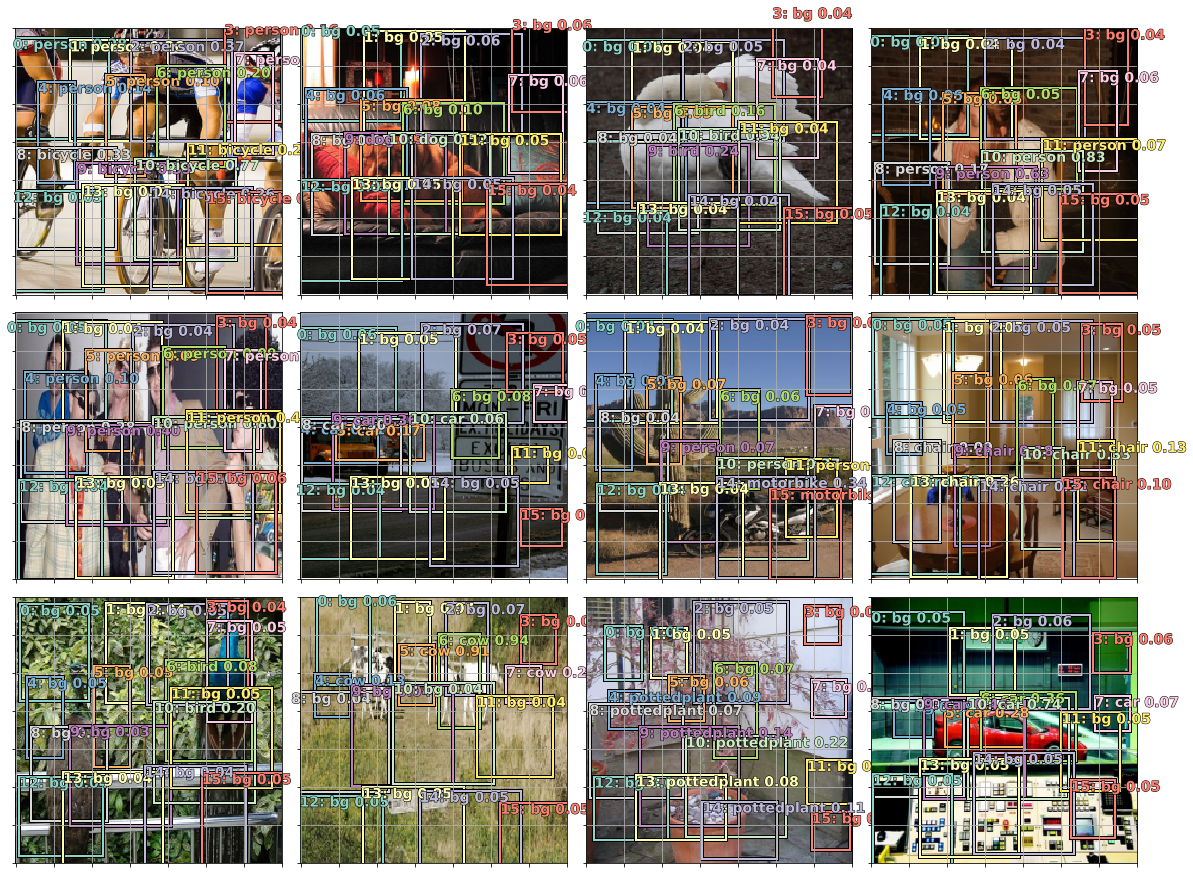

In [135]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(bbox,clas); bbox,clas
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.01)
plt.tight_layout()